In [1]:
!python --version

Python 3.12.4


# 0 - Imports - Load Data

In [2]:
import numpy as np
import pandas as pd

import re
from dateutil import parser
import unicodedata

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer #,IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

import warnings
warnings.filterwarnings("ignore")

In [4]:
test       = pd.read_csv('data\\test_x.csv').drop(['id'],axis=1)
train      = pd.read_csv('data\\train.csv').drop(['id'],axis=1)
train_copy = pd.read_csv('data\\train.csv').drop(['id'],axis=1)


In [5]:
target_col = 'Degerlendirme Puani'
categoric_cols = [col for col in train.columns if train[col].dtype == 'O']
numeric_cols = [col for col in train.columns if train[col].dtype != 'O']
numeric_cols.remove(target_col)

col_test_none = ["Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite","Lise Adi Diger","Ingilizce Seviyeniz?","Stk Projesine Katildiniz Mi?",
                 "Burslu ise Burs Yuzdesi","Lise Bolum Diger","Daha Once Baska Bir Universiteden Mezun Olmus","Uye Oldugunuz Kulubun Ismi"]

# col_train_none = ["Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite","Lise Adi Diger","Ingilizce Seviyeniz?","Stk Projesine Katildiniz Mi?",
#                  "Burslu ise Burs Yuzdesi","Lise Bolum Diger","Daha Once Baska Bir Universiteden Mezun Olmus","Uye Oldugunuz Kulubun Ismi"]


In [6]:
train = train[train['Basvuru Yili'] != 2016]
train = train[train['Basvuru Yili'] != 2019]
train = train.dropna(subset=["Degerlendirme Puani"])

test  = test.drop(columns=col_test_none)
#train = train.drop(columns=col_test_none)

In [7]:
for yil in list(train["Basvuru Yili"].unique()):
    cond = train["Basvuru Yili"] == yil
    adding = 30.50 - train.loc[cond,"Degerlendirme Puani"].mean()
    train.loc[cond,"Degerlendirme Puani"] = train.loc[cond,"Degerlendirme Puani"] + adding

In [8]:
# # Mean eşitleme kodu

# for yil in list(train["Basvuru Yili"].unique()):
#     cond = train["Basvuru Yili"] == yil
#     adding = 30.5 - train.loc[cond,"Degerlendirme Puani"].mean()
#     train.loc[cond,"Degerlendirme Puani"] = train.loc[cond,"Degerlendirme Puani"] + adding

In [9]:
#test.isnull().mean().sort_values(ascending=False)*100

# 1 - Veri Temizleme

In [10]:
# Mapping of Turkish month names to English
turkish_to_english_months = {
    "Ocak": "January",
    "Şubat": "February",
    "Subat": "February",
    "Mart": "March",
    "Nisan": "April",
    "Mayıs": "May",
    "Mayis": "May",
    "Haziran": "June",
    "Temmuz": "July",
    "Ağustos": "August",
    "Agustos": "August",
    "Eylül": "September",
    "Eylul": "September",
    "Ekim": "October",
    "Kasım": "November",
    "Kasim": "November",
    "Aralık": "December",
    "Aralik": "December"
}

def normalize_turkish_months(date_str):
    for turkish_month, english_month in turkish_to_english_months.items():
        date_str = re.sub(r'\b' + turkish_month + r'\b', english_month, date_str)
    return date_str

def extract_year(date_str):
    if not isinstance(date_str, str):
        return None  # Return None if the input is not a string
    try:
        # Normalize the date string for Turkish month names
        date_str = normalize_turkish_months(date_str)
        
        # Parse the date string using dateutil.parser
        parsed_date = parser.parse(date_str, fuzzy=True, dayfirst=False)
        
        # Extract the year from the parsed date
        return parsed_date.year
    except (ValueError, TypeError):
        # If parsing fails, try extracting the year directly from the string
        year_match = re.search(r'(\d{4})$', date_str)
        if year_match:
            return int(year_match.group(1))
        return None
    


def normalize_turkish_with_unicode(text):

    if text =="nan" or text=='np.nan' or text == 'none':
        return np.nan  # Keep np.nan as it is
    # Normalize the text to decompose combined characters (NFKD form)
    normalized_text = unicodedata.normalize('NFKD', text)
    
    # Remove diacritical marks (characters with combining marks)
    ascii_text = ''.join(c for c in normalized_text if not unicodedata.combining(c))
    
    # Additional replacements for Turkish-specific characters
    turkish_to_ascii = {
        'ç': 'c', 'Ç': 'C',
        'ğ': 'g', 'Ğ': 'G',
        'ı': 'i', 'İ': 'i',
        'ö': 'o', 'Ö': 'O',
        'ş': 's', 'Ş': 'S',
        'ü': 'u', 'Ü': 'U'
    }
    
    # Replace Turkish characters with ASCII equivalents
    ascii_text = ''.join(turkish_to_ascii.get(c, c) for c in ascii_text)
    
    return ascii_text.lower()

def temizle_sehir(sehir):
    if pd.isna(sehir):
        return None
    if isinstance(sehir, str):
        sehir = sehir.lower()
        sehir = sehir.strip()

        for il in sehirler:
            if il.lower() in sehir:
                return il.capitalize()
    return None

sehirler = [
    "Adana", "Adıyaman", "Afyonkarahisar", "Ağrı", "Aksaray", "Amasya", "Ankara", "Antalya",
    "Ardahan", "Artvin", "Aydın", "Balıkesir", "Bartın", "Batman", "Bayburt", "Bilecik", "Bingöl",
    "Bitlis", "Bolu", "Burdur", "Bursa", "Çanakkale", "Çankırı", "Çorum", "Denizli", "Diyarbakır",
    "Düzce", "Edirne", "Elazığ", "Erzincan", "Erzurum", "Eskişehir", "Gaziantep", "Giresun", "Gümüşhane",
    "Hakkari", "Hatay", "Iğdır", "Isparta", "İstanbul", "İzmir", "Kahramanmaraş", "Karabük", "Karaman",
    "Kars", "Kastamonu", "Kayseri", "Kilis", "Kırıkkale", "Kırklareli", "Kırşehir", "Kocaeli", "Konya",
    "Kütahya", "Malatya", "Manisa", "Mardin", "Mersin", "Muğla", "Muş", "Nevşehir", "Niğde", "Ordu",
    "Osmaniye", "Rize", "Sakarya", "Samsun", "Siirt", "Sinop", "Sivas", "Şanlıurfa", "Şırnak", "Tekirdağ",
    "Tokat", "Trabzon", "Tunceli", "Uşak", "Van", "Yalova", "Yozgat", "Zonguldak"
]

sehirler = list(map(normalize_turkish_with_unicode,sehirler))

sehir_col_list = ["Dogum Yeri", "Ikametgah Sehri", "Lise Sehir"]

def temizle_baska_kurum(kurum):
    if pd.isna(kurum):
        return "almiyor"
    if isinstance(kurum, str):
        kurum = kurum.lower()
        kurum = kurum.strip()
            
        if "kredi" in kurum:
            return "kyk"
        
        elif "devlet" in kurum:
            return "kyk"
        
        elif "-" == kurum:
            return "almiyor"
        
        elif "k" == kurum:
            return "kyk"
        
        elif "ky" in kurum:
            return "kyk"
        
        else:
            return "diger"

    return kurum

def temizle_burs_miktari(burs):
    if pd.isna(burs):
        return "almiyor"
    if isinstance(burs, str):
        burs = burs.lower()
        burs = burs.strip()
        
        if "-" == burs:
            return "almiyor"
        
        else:
            return "aliyor"

    return burs

def temizle_bolum(bolum):
    if pd.isna(bolum):
        return None
    if isinstance(bolum, str):
        bolum = bolum.lower()
        bolum = bolum.strip()

        for bolum_i in bolumler:
            if bolum_i.lower() in bolum:
                return bolum_i.lower()
    return bolum


def temizle_stk(stk):
    if pd.isna(stk):
        return "almiyor"
    if isinstance(stk, str):
        stk = stk.lower()
        stk = stk.strip()
            
        if "kizilay" in stk:
            return "kizilay"
        
        elif "-" == stk:
            return "Hayır"
        
        elif "Hayır" == stk:
            return "Hayır"
        
        elif "afad" in stk:
            return "afad"
        
        elif "acil" in stk:
            return "afad"
        
        elif "afet" in stk:
            return "afad"
        
        elif "deprem" in stk:
            return "afad"
        
        elif "tema" in stk:
            return "tema"
        
        elif "yesilay" in stk:
            return "yesilay"
        
        elif "tema" in stk:
            return "tema"
        
        elif "tubitak" in stk:
            return "tubitak"
        
        elif "losev" in stk:
            return "losev"
        
        elif "tegv" in stk:
            return "tegv"
        
        elif "tog" in stk:
            return "tog"
        
        elif "toplum" in stk:
            return "tog"
        
        elif "agac" in stk:
            return "tema"
        
        elif "fidan" in stk:
            return "tema"
        
        elif "cevre" in stk:
            return "tema"
        
        elif "kan" in stk:
            return "kizilay"
        
        elif "okul" in stk:
            return "tegv"
        
        elif "sosyal" in stk:
            return "sosyal"
        
        elif "hayvan" in stk:
            return "hayvan"
        
        elif "egit" in stk:
            return "tegv"
        
        elif "genc" in stk:
            return "genc"
        
        elif "cocuk" in stk:
            return "cocuk"
        
        elif "kadin" in stk:
            return "kadin"
        
        elif "kiz" in stk:
            return "kadin"
        
        else:
            return "diger"

def temizle_lise_bolum(lise_bolum):
    if pd.isna(lise_bolum):
        return None
    if isinstance(lise_bolum, str):
        lise_bolum = lise_bolum.lower()
        lise_bolum = lise_bolum.strip()
            
        if "fen" in lise_bolum:
            return "sayisal"
        
        if "sayisal" in lise_bolum:
            return "sayisal"
        
        elif "esit" in lise_bolum:
            return "esit agirlik"
        
        elif "turkce" in lise_bolum:
            return "esit agirlik"
        
        elif "sozel" in lise_bolum:
            return "sozel"
        
        elif "dil" in lise_bolum:
            return "dil"
        
        elif "mf" in lise_bolum:
            return "sayisal"
        
        elif "tm" in lise_bolum:
            return "esit agirlik"
        
        elif "dil" in lise_bolum:
            return "dil"
        
        elif "sosyal" in lise_bolum:
            return "sozel"
        
        else:
            return "sozel"

    return lise_bolum

bolumler = [
    "makine", "endustri", "elektronik","insaat","mekatronik","metalurji","cevre","petrol","maden","gida","ucak",
    "Uzay","robotik","otomotiv","tekstil","bilgisayar muhendisligi","yazilim"
    ]

train.loc[train["Lise Adi"] == '------',"Lise Adi"] = train["Lise Adi Diger"]
top_50_lise         = train['Lise Adi'].astype(str).apply(normalize_turkish_with_unicode).value_counts().nlargest(50).index
top_50_universities = train['Universite Adi'].astype(str).apply(normalize_turkish_with_unicode).value_counts().nlargest(50).index
top_50_bolum        = train['Bölüm'].astype(str).apply(normalize_turkish_with_unicode).apply(temizle_bolum).value_counts().nlargest(50).index

uni_sinif_mapping = {'1': 1, '2': 2, '3': 3,'4': 4, '5': 5,'6':6,'yuksek lisans':6,'tez':6,'mezun':5,"hazirlik":"Hazırlık", "0":"Hazırlık","Hazırlık":"Hazırlık"}

lise_turu_mapping = {'anadolu lisesi': "devlet", 'diger': "devlet", 'devlet': "devlet",'duz lise': "devlet", 'ozel': "ozel",
                     'meslek lisesi':"devlet",'meslek':"devlet",'fen lisesi':"devlet",'ozel lisesi':"ozel","imam hatip lisesi":"devlet"}

anne_egitim_mapping = {"doktora":"doktora",
                       "egitim yok":"egitimi yok",
                       "egitimi yok":"egitimi yok",
                       "ilkokul":"ilkokul",
                       "ilkokul mezunu":"ilkokul",
                       "lise":"lise","lise mezunu":"lise",
                       "ortaokul":"ortaokul","ortaokul mezunu":"ortaokul",
                       "universite":"universite","universite mezunu":"universite",
                       "yuksek lisans":"yuksek lisans","yuksek lisans / doktara":"yuksek lisans",
                       "yuksek lisans / doktora":"yuksek lisans"}

baba_egitim_mapping = {"doktora":"doktora",
                       "egitim yok":"egitimi yok",
                       "egitimi yok":"egitimi yok",
                       "ilkokul":"ilkokul",
                       "ilkokul mezunu":"ilkokul",
                       "lise":"lise","lise mezunu":"lise",
                       "ortaokul":"ortaokul","ortaokul mezunu":"ortaokul",
                       "universite":"universite","universite mezunu":"universite",
                       "yuksek lisans":"yuksek lisans","yuksek lisans / doktara":"doktora",
                       "yuksek lisans / doktora":"doktora"}

lise_not_mapping = {"0 - 24": "25 - 49",
                    "25 - 49": "25 - 49",
                    "25 - 50": "25 - 49",
                    "50 - 75": "50 - 74",
                    "50 - 74": "50 - 74",
                    "Not ortalaması yok": "75 - 100",
                    "75 - 100": "75 - 100",
                     np.nan : "50 - 74",
                    "0 - 25": "25 - 49",
                    "100-85": "75 - 100",
                    "44-0" : "25 - 49",
                    "54-45": "50 - 74",
                    "69-55": "50 - 74",
                    "84-70": "75 - 100",
                    "2.50 ve altı": "25 - 49",
                    "3.00 - 4.00" : "75 - 100",
                    "3.50-3"    : "75 - 100",
                    "3.00-2.50" : "50 - 74",
                    "3.50-3.00" : "75 - 100",
                    "4.00-3.50" : "75 - 100"}

uni_not_mapping = {"Not ortalaması yok": "Hazırlığım",
                    np.nan : "0 - 1.79",
                    "1.00 - 2.50": "0 - 1.79",
                    "2.00 - 2.50": "1.80 - 2.49",
                    "2.50 - 3.00": "2.50 - 2.99",
                    "3.00 - 3.50": "3.00 - 3.49",
                    "3.50 - 4.00": "3.50 - 4.00",
                    "2.50 ve altı": "1.80 - 2.49",
                    "3.00-2.50"  : "2.50 - 2.99",
                    "3.50-3"     : "3.00 - 3.49",
                    "4-3.5"      : "3.50 - 4.00",
                    "Hazırlığım"  : "Hazırlığım",
                    "0 - 1.79"    : "0 - 1.79",
                    "1.80 - 2.49" : "1.80 - 2.49",
                    "2.50 - 2.99" : "2.50 - 2.99",
                    "3.00 - 3.49" : "3.00 - 3.49",
                    "3.50 - 4.00" : "3.50 - 4.00",
                    "4.0-3.5"    : "3.50 - 4.00",
                    "3.00 - 4.00": "3.00 - 3.49",
                    "ORTALAMA BULUNMUYOR": "0 - 1.79"}

spor_rol_mapping = {"-":"-",
                    "Bireysel Spor":"Bireysel Spor",
                    "Takım Oyuncusu":"Takım Oyuncusu",
                    "Lider/Kaptan":"Lider/Kaptan",
                    "Diğer":"Diğer",
                    np.nan:"-","Bireysel":"Bireysel Spor",
                    "KAPTAN / LİDER":"Lider/Kaptan",
                    "DİĞER":"Diğer",
                    "Kaptan":"Lider/Kaptan","0":"-"}

In [11]:
def train_data_prep(train_df):
    
    train_df_preped = pd.DataFrame()
 
    # Basvuru Yili
    train_df_preped["Basvuru Yili"] = train_df[["Basvuru Yili"]].astype(str)
    

    # Degerlendirme Puani
    train_df_preped["Degerlendirme Puani"] = train_df["Degerlendirme Puani"]#.dropna(subset=["Degerlendirme Puani"])

    # Cinsiyet
    train_df_preped['Cinsiyet'] = train_df['Cinsiyet'].str.capitalize()
    #train_df_preped             = train_df_preped.dropna(subset=["Cinsiyet"])

    # Dogum Yili
    train_df_preped['Dogum Yili'] = train_df['Dogum Tarihi'].apply(extract_year)
    train_df_preped['Dogum Yili'] = train_df_preped['Dogum Yili'].apply(lambda x: np.nan if (x > 2005) | (x < 1990) else x)

    # Basvuru Yası
    train_df_preped['Basvuru Yasi'] = train_df_preped['Basvuru Yili'].astype(float) - train_df_preped['Dogum Yili']
    train_df_preped['Basvuru Yasi'] = train_df_preped['Basvuru Yasi'].apply(lambda x: 18 if (x < 18) else x)
    train_df_preped['Basvuru Yasi'] = train_df_preped['Basvuru Yasi'].apply(lambda x: 25 if (x > 25) else x)

    # Dogum Yeri, Ikametgah Sehri, Lise Sehir
    for col in sehir_col_list:
        train_df_preped[col] = train_df[col].astype(str).apply(normalize_turkish_with_unicode)
        train_df_preped[col] = train_df_preped[col].apply(temizle_sehir)
        train_df_preped[col] = train_df_preped[col].fillna('diger')

    # Universite Adi
    train_df_preped['Universite Adi'] = train_df['Universite Adi'].astype(str).apply(normalize_turkish_with_unicode)
    train_df_preped['Universite Adi'] = train_df_preped['Universite Adi'].where(train_df['Universite Adi'].isin(top_50_universities), "diger")

    # Lise Adi
    train_df_preped['Lise Adi'] = train_df['Lise Adi'].astype(str).apply(normalize_turkish_with_unicode)
    train_df_preped['Lise Adi'] = train_df_preped['Lise Adi'].where(train_df['Lise Adi'].isin(top_50_lise), "diger")

    #Universite Turu 
    train_df_preped['Universite Turu'] = train_df['Universite Turu'].str.capitalize()

    #Burs Aliyor mu?
    train_df_preped['Burs Aliyor mu?'] = train_df['Burs Aliyor mu?'].str.capitalize()

    #Baska Bir Kurumdan Burs Aliyor mu?
    train_df_preped['Baska Bir Kurumdan Burs Aliyor mu?'] = train_df['Baska Bir Kurumdan Burs Aliyor mu?'].astype(str).apply(normalize_turkish_with_unicode)
    train_df_preped['Baska Bir Kurumdan Burs Aliyor mu?'] = train_df_preped['Baska Bir Kurumdan Burs Aliyor mu?'].fillna("hayir")
    
    #Burs Aldigi Baska Kurum
    train_df_preped['Burs Aldigi Baska Kurum'] = train_df['Burs Aldigi Baska Kurum'].astype(str).apply(normalize_turkish_with_unicode)
    train_df_preped["Burs Aldigi Baska Kurum"] = train_df_preped["Burs Aldigi Baska Kurum"].apply(temizle_baska_kurum)
    
    #Bölüm
    train_df_preped['Bölüm'] = train_df['Bölüm'].astype(str).apply(normalize_turkish_with_unicode)
    train_df_preped["Bölüm"] = train_df_preped["Bölüm"].apply(temizle_bolum)
    train_df_preped['Bölüm'] = train_df_preped['Bölüm'].where(train_df_preped['Bölüm'].isin(top_50_bolum), "diger")

    

    #Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?
    train_df.loc[(train_df['Basvuru Yili'] != 2014) & (train_df['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'].isna()), 'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] = 'Hayır'
    train_df_preped["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"] = train_df["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"]

    #Aktif olarak bir STK üyesi misiniz?
    train_df.loc[(train_df['Basvuru Yili'] != 2014) & (train_df['Aktif olarak bir STK üyesi misiniz?'].isna()), 'Aktif olarak bir STK üyesi misiniz?'] = 'Hayır'
    train_df_preped['Aktif olarak bir STK üyesi misiniz?'] = train_df['Aktif olarak bir STK üyesi misiniz?']
    #train_df_preped             = train_df_preped.dropna(subset=["Aktif olarak bir STK üyesi misiniz?"])

    # Profesyonel Bir Spor Daliyla Mesgul musunuz?	
    train_df.loc[(train_df['Basvuru Yili'] != 2014) & (train_df['Profesyonel Bir Spor Daliyla Mesgul musunuz?'].isna()), 'Profesyonel Bir Spor Daliyla Mesgul musunuz?'] = 'Hayır'
    train_df_preped['Profesyonel Bir Spor Daliyla Mesgul musunuz?'] = train_df['Profesyonel Bir Spor Daliyla Mesgul musunuz?']

    # Lise Mezuniyet Notu
    train_df_preped['Lise Mezuniyet Notu'] = train_df['Lise Mezuniyet Notu'].map(lise_not_mapping)

    # Universite Not Ortalamasi
    train_df_preped['Universite Not Ortalamasi'] = train_df['Universite Not Ortalamasi'].map(uni_not_mapping)
    
    # Girisimcilikle Ilgili Deneyiminiz Var Mi?
    train_df_preped["Girisimcilikle Ilgili Deneyiminiz Var Mi?"] = train_df["Girisimcilikle Ilgili Deneyiminiz Var Mi?"]

    # Universite Kacinci Sinif
    train_df_preped['Universite Kacinci Sinif'] = train_df['Universite Kacinci Sinif'].map(uni_sinif_mapping)

    # Spor Dalindaki Rolunuz Nedir?
    train_df_preped["Spor Dalindaki Rolunuz Nedir?"] = train_df["Spor Dalindaki Rolunuz Nedir?"].map(spor_rol_mapping)

    # Ingilizce Biliyor musunuz?
    train_df_preped["Ingilizce Biliyor musunuz?"] = train_df["Ingilizce Biliyor musunuz?"]

    # Lise Turu
    train_df_preped["Lise Turu"] = train_df["Lise Turu"].astype(str).apply(normalize_turkish_with_unicode)
    train_df_preped['Lise Turu'] = train_df_preped['Lise Turu'].map(lise_turu_mapping)

    # Lise Bolumu
    train_df_preped['Lise Bolumu'] = train_df['Lise Bolumu'].astype(str).apply(normalize_turkish_with_unicode)
    train_df_preped["Lise Bolumu"] = train_df_preped["Lise Bolumu"].apply(temizle_lise_bolum)
    
    # Anne Egitim Durumu
    train_df_preped['Anne Egitim Durumu'] = train_df['Anne Egitim Durumu'].astype(str).apply(normalize_turkish_with_unicode)
    train_df_preped["Anne Egitim Durumu"] = train_df_preped["Anne Egitim Durumu"].map(anne_egitim_mapping)

    # Anne Calisma Durumu
    train_df_preped['Anne Calisma Durumu'] = train_df['Anne Calisma Durumu']
    train_df_preped['Anne Calisma Durumu'] = train_df_preped['Anne Calisma Durumu'].fillna('Hayır')
    train_df_preped['Anne Calisma Durumu'] = train_df_preped['Anne Calisma Durumu'].replace('Emekli', 'Evet')

    # Anne Sektor
    train_df_preped['Anne Sektor'] = train_df['Anne Sektor'].astype(str).apply(normalize_turkish_with_unicode)
    train_df_preped['Anne Sektor'] = train_df_preped['Anne Sektor'].fillna('-')
    train_df_preped['Anne Sektor'] = train_df_preped['Anne Sektor'].replace('0', '-')


    return train_df_preped

def test_data_prep(test_df):

    # Dogum Yili
    test_df['Dogum Yili'] = test_df['Dogum Tarihi'].apply(extract_year)
    test_df['Dogum Yili'] = test_df['Dogum Yili'].apply(lambda x: np.nan if (x > 2005) | (x < 1990) else x)

    # Basvuru Yası
    test_df['Basvuru Yasi'] = 2023 - test_df['Dogum Yili']
    test_df['Basvuru Yasi'] = test_df['Basvuru Yasi'].apply(lambda x: 18 if (x < 18) else x)
    test_df['Basvuru Yasi'] = test_df['Basvuru Yasi'].apply(lambda x: 25 if (x > 25) else x)

    # Dogum Yeri, Ikametgah Sehri, Lise Sehir
    for col in sehir_col_list:
        test_df[col] = test_df[col].astype(str).apply(normalize_turkish_with_unicode)
        test_df[col] = test_df[col].apply(temizle_sehir)

    # Universite Adi
    test_df['Universite Adi'] = test_df['Universite Adi'].astype(str).apply(normalize_turkish_with_unicode)
    test_df['Universite Adi'] = test_df['Universite Adi'].where(test_df['Universite Adi'].isin(top_50_universities), "diger")

    # Lise Adi
    test_df['Lise Adi'] = test_df['Lise Adi'].astype(str).apply(normalize_turkish_with_unicode)
    test_df['Lise Adi'] = test_df['Lise Adi'].where(test_df['Lise Adi'].isin(top_50_lise), "diger")

    #Burs Aldigi Baska Kurum
    test_df['Burs Aldigi Baska Kurum'] = test_df['Burs Aldigi Baska Kurum'].astype(str).apply(normalize_turkish_with_unicode)
    test_df["Burs Aldigi Baska Kurum"] = test_df["Burs Aldigi Baska Kurum"].apply(temizle_baska_kurum)

    #Bölüm
    test_df['Bölüm'] = test_df['Bölüm'].astype(str).apply(normalize_turkish_with_unicode)
    test_df["Bölüm"] = test_df["Bölüm"].apply(temizle_bolum)
    test_df['Bölüm'] = test_df['Bölüm'].where(test_df['Bölüm'].isin(top_50_bolum), "diger")

    # Lise Turu
    test_df["Lise Turu"] = test_df["Lise Turu"].astype(str).apply(normalize_turkish_with_unicode)

    # Universite Kacinci Sinif
    test_df['Universite Kacinci Sinif'] = test_df['Universite Kacinci Sinif'].map(uni_sinif_mapping)

    #Lise Bolumu
    test_df['Lise Bolumu'] = test_df['Lise Bolumu'].astype(str).apply(normalize_turkish_with_unicode)
    test_df["Lise Bolumu"] = test_df["Lise Bolumu"].apply(temizle_lise_bolum)

    # Anne Calisma Durumu
    test_df['Anne Calisma Durumu'] = test_df['Anne Calisma Durumu']

    # Anne Egitim Durumu
    test_df['Anne Egitim Durumu'] = test_df['Anne Egitim Durumu'].astype(str).apply(normalize_turkish_with_unicode)

    # Anne Sektor
    test_df['Anne Sektor'] = test_df['Anne Sektor'].astype(str).apply(normalize_turkish_with_unicode)
    
    return test_df

In [12]:
train.columns

Index(['Basvuru Yili', 'Degerlendirme Puani', 'Cinsiyet', 'Dogum Tarihi',
       'Dogum Yeri', 'Ikametgah Sehri', 'Universite Adi', 'Universite Turu',
       'Burslu ise Burs Yuzdesi', 'Burs Aliyor mu?', 'Bölüm',
       'Universite Kacinci Sinif', 'Universite Not Ortalamasi',
       'Daha Once Baska Bir Universiteden Mezun Olmus', 'Lise Adi',
       'Lise Adi Diger', 'Lise Sehir', 'Lise Turu', 'Lise Bolumu',
       'Lise Bolum Diger', 'Lise Mezuniyet Notu',
       'Baska Bir Kurumdan Burs Aliyor mu?', 'Burs Aldigi Baska Kurum',
       'Baska Kurumdan Aldigi Burs Miktari', 'Anne Egitim Durumu',
       'Anne Calisma Durumu', 'Anne Sektor', 'Baba Egitim Durumu',
       'Baba Calisma Durumu', 'Baba Sektor', 'Kardes Sayisi',
       'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?',
       'Uye Oldugunuz Kulubun Ismi',
       'Profesyonel Bir Spor Daliyla Mesgul musunuz?',
       'Spor Dalindaki Rolunuz Nedir?', 'Aktif olarak bir STK üyesi misiniz?',
       'Hangi STK'nin Uyesisiniz?', 

In [13]:
#train datasındaki nanları handle eden kod lazım.
#cinsiyet nanları kick

def train_data_nan_clean(train_df):

    # Degerlendirme Puani
    train_df = train_df.dropna(subset=["Degerlendirme Puani"])

    # Cinsiyet
    train_df = train_df.dropna(subset=["Cinsiyet"])

    # Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?
    train_df = train_df.dropna(subset=["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"])

    train_df = train_df.dropna(subset=["Universite Turu"])

    train_df = train_df.dropna(subset=["Anne Egitim Durumu"])

    
    return train_df

In [14]:
def train_data_encode(train_df):

    train_preped_df = pd.DataFrame()

    # Basvuru Yili
    basvuru_yili_encoded = pd.get_dummies(train_df[["Basvuru Yili"]], columns=["Basvuru Yili"],drop_first=True)

    # Cinsiyet
    cinsiyet_encoded = pd.get_dummies(train_df[["Cinsiyet"]], columns=["Cinsiyet"],drop_first=True)

    # Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?
    girisimcilik_kulup_uye = pd.get_dummies(train_df[["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"]], columns=["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"],drop_first=True)

    # Aktif olarak bir STK üyesi misiniz?
    stk_aktif_uye = pd.get_dummies(train_df[["Aktif olarak bir STK üyesi misiniz?"]], columns=["Aktif olarak bir STK üyesi misiniz?"],drop_first=True)

    # Profesyonel Bir Spor Daliyla Mesgul musunuz?
    pro_spor_dali = pd.get_dummies(train_df[["Profesyonel Bir Spor Daliyla Mesgul musunuz?"]], columns=["Profesyonel Bir Spor Daliyla Mesgul musunuz?"],drop_first=True)

    # Universite Turu
    uni_turu_dali = pd.get_dummies(train_df[["Universite Turu"]], columns=["Universite Turu"],drop_first=True)

    # Burs Aliyor mu?
    burs_aliyor_mu = pd.get_dummies(train_df[["Burs Aliyor mu?"]], columns=["Burs Aliyor mu?"],drop_first=True)

    # Burs Aldigi Baska Kurum
    burs_baska_kurum = pd.get_dummies(train_df[["Burs Aldigi Baska Kurum"]], columns=["Burs Aldigi Baska Kurum"],drop_first=True)

    # Lise Mezuniyet Notu
    lise_not = pd.get_dummies(train_df[["Lise Mezuniyet Notu"]], columns=["Lise Mezuniyet Notu"],drop_first=True)

    # Universite Not Ortalamasi
    uni_not = pd.get_dummies(train_df[["Universite Not Ortalamasi"]], columns=["Universite Not Ortalamasi"],drop_first=True)

    # Girisimcilikle Ilgili Deneyiminiz Var Mi?
    girisim_deneyim = pd.get_dummies(train_df[["Girisimcilikle Ilgili Deneyiminiz Var Mi?"]], columns=["Girisimcilikle Ilgili Deneyiminiz Var Mi?"],drop_first=True)

    # Spor Dalindaki Rolunuz Nedir?
    spor_rol = pd.get_dummies(train_df[["Spor Dalindaki Rolunuz Nedir?"]], columns=["Spor Dalindaki Rolunuz Nedir?"],drop_first=True)

    # Ingilizce Biliyor musunuz?
    ing_biliyor = pd.get_dummies(train_df[["Ingilizce Biliyor musunuz?"]], columns=["Ingilizce Biliyor musunuz?"],drop_first=True)

    uni_sinif = pd.get_dummies(train_df[["Universite Kacinci Sinif"]], columns=["Universite Kacinci Sinif"],drop_first=True)
    lise_turu = pd.get_dummies(train_df[["Lise Turu"]], columns=["Lise Turu"],drop_first=True)
    lise_bolum= pd.get_dummies(train_df[["Lise Bolumu"]], columns=["Lise Bolumu"],drop_first=True)
    anne_calis= pd.get_dummies(train_df[["Anne Calisma Durumu"]], columns=["Anne Calisma Durumu"],drop_first=True)
    anne_egit = pd.get_dummies(train_df[["Anne Egitim Durumu"]], columns=["Anne Egitim Durumu"],drop_first=True)
    anne_sekt = pd.get_dummies(train_df[["Anne Sektor"]], columns=["Anne Sektor"],drop_first=True)

    
    # Dogum Yili
    #DFleri birlestirme
    train_preped_df = pd.concat([basvuru_yili_encoded,
        cinsiyet_encoded, girisimcilik_kulup_uye,stk_aktif_uye,pro_spor_dali,uni_turu_dali,
                                 burs_aliyor_mu,burs_baska_kurum,lise_not,uni_not,girisim_deneyim,spor_rol,ing_biliyor,
                                uni_sinif,lise_turu,lise_bolum,anne_calis,anne_egit,anne_sekt], axis=1)

    #train_preped_df["Degerlendirme Puani"] = train_df["Degerlendirme Puani"]
    train_preped_df["Dogum Yili"]           = train_df["Dogum Yili"].astype(str)
    train_preped_df["Basvuru Yasi"]         = train_df["Basvuru Yasi"].astype(str)
    train_preped_df[sehir_col_list]         = train_df[sehir_col_list]
    train_preped_df['Universite Adi']       = train_df['Universite Adi']
    train_preped_df['Bölüm']                = train_df['Bölüm']
    train_preped_df['Lise Adi']             = train_df['Lise Adi']
    train_preped_df["Degerlendirme Puani"]  = train_df["Degerlendirme Puani"]
    return train_preped_df

def test_data_encode(train_df,test_df):
    
    
    # Basvuru Yili
    basvuru_yili_encoded = pd.DataFrame(index=range(len(test_df)))
    basvuru_yili_encoded[[col for col in train_df.columns if col.startswith('Basvuru Yili')]] = False
    basvuru_yili_encoded["Basvuru Yili_2022"] = True

    # Cinsiyet
    cinsiyet_encoded = pd.get_dummies(test_df[["Cinsiyet"]], columns=["Cinsiyet"],drop_first=True)

    # Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?
    girisimcilik_kulup_uye = pd.get_dummies(test_df[["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"]], columns=["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"],drop_first=True)

    # Aktif olarak bir STK üyesi misiniz?
    stk_aktif_uye = pd.get_dummies(test_df[["Aktif olarak bir STK üyesi misiniz?"]], columns=["Aktif olarak bir STK üyesi misiniz?"],drop_first=True)

    # Profesyonel Bir Spor Daliyla Mesgul musunuz?
    pro_spor_dali = pd.get_dummies(test_df[["Profesyonel Bir Spor Daliyla Mesgul musunuz?"]], columns=["Profesyonel Bir Spor Daliyla Mesgul musunuz?"],drop_first=True)

    # Universite Turu
    uni_turu_dali = pd.get_dummies(test_df[["Universite Turu"]], columns=["Universite Turu"],drop_first=True)

    # Burs Aliyor mu?
    burs_aliyor_mu = pd.get_dummies(test_df[["Burs Aliyor mu?"]], columns=["Burs Aliyor mu?"],drop_first=True)

    # Burs Aldigi Baska Kurum
    burs_baska_kurum = pd.get_dummies(test_df[["Burs Aldigi Baska Kurum"]], columns=["Burs Aldigi Baska Kurum"],drop_first=True)

    # Lise Mezuniyet Notu
    lise_not = pd.get_dummies(test_df[["Lise Mezuniyet Notu"]], columns=["Lise Mezuniyet Notu"],drop_first=True)

    # Universite Not Ortalamasi
    uni_not = pd.get_dummies(test_df[["Universite Not Ortalamasi"]], columns=["Universite Not Ortalamasi"],drop_first=True)

    # Girisimcilikle Ilgili Deneyiminiz Var Mi?
    girisim_deneyim = pd.get_dummies(test_df[["Girisimcilikle Ilgili Deneyiminiz Var Mi?"]], columns=["Girisimcilikle Ilgili Deneyiminiz Var Mi?"],drop_first=True)

    # Spor Dalindaki Rolunuz Nedir?
    spor_rol = pd.get_dummies(test_df[["Spor Dalindaki Rolunuz Nedir?"]], columns=["Spor Dalindaki Rolunuz Nedir?"],drop_first=True)

    # Ingilizce Biliyor musunuz?
    ing_biliyor = pd.get_dummies(test_df[["Ingilizce Biliyor musunuz?"]], columns=["Ingilizce Biliyor musunuz?"],drop_first=True)

    uni_sinif = pd.get_dummies(test_df[["Universite Kacinci Sinif"]], columns=["Universite Kacinci Sinif"],drop_first=True)
    lise_turu = pd.get_dummies(test_df[["Lise Turu"]], columns=["Lise Turu"],drop_first=True)
    lise_bolum= pd.get_dummies(test_df[["Lise Bolumu"]], columns=["Lise Bolumu"],drop_first=True)
    anne_calis= pd.get_dummies(test_df[["Anne Calisma Durumu"]], columns=["Anne Calisma Durumu"],drop_first=True)
    anne_egit = pd.get_dummies(test_df[["Anne Egitim Durumu"]], columns=["Anne Egitim Durumu"],drop_first=True)
    anne_sekt = pd.get_dummies(test_df[["Anne Sektor"]], columns=["Anne Sektor"],drop_first=True)
    

    #DFleri birlestirme
    test_preped_df = pd.concat([basvuru_yili_encoded,
                                cinsiyet_encoded, girisimcilik_kulup_uye,stk_aktif_uye,pro_spor_dali,uni_turu_dali,
                                burs_aliyor_mu,burs_baska_kurum,lise_not,uni_not,girisim_deneyim,spor_rol,ing_biliyor,
                                uni_sinif,lise_turu,lise_bolum,anne_calis,anne_egit,anne_sekt], axis=1)

    test_preped_df["Dogum Yili"]           = test_df["Dogum Yili"].astype(str)
    test_preped_df["Basvuru Yasi"]         = test_df["Basvuru Yasi"].astype(str)
    test_preped_df[sehir_col_list]         = test_df[sehir_col_list]
    test_preped_df['Universite Adi']       = test_df['Universite Adi']
    test_preped_df['Bölüm']                = test_df['Bölüm']
    test_preped_df['Lise Adi']             = test_df['Lise Adi']


    
    return test_preped_df



In [15]:
train_preped = train_data_nan_clean(train_data_prep(train))
train_preped.head(2)

,Basvuru Yili,Degerlendirme Puani,Cinsiyet,Dogum Yili,Basvuru Yasi,Dogum Yeri,Ikametgah Sehri,Lise Sehir,Universite Adi,Lise Adi,Universite Turu,Burs Aliyor mu?,Baska Bir Kurumdan Burs Aliyor mu?,Burs Aldigi Baska Kurum,Bölüm,Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?,Aktif olarak bir STK üyesi misiniz?,Profesyonel Bir Spor Daliyla Mesgul musunuz?,Lise Mezuniyet Notu,Universite Not Ortalamasi,Girisimcilikle Ilgili Deneyiminiz Var Mi?,Universite Kacinci Sinif,Spor Dalindaki Rolunuz Nedir?,Ingilizce Biliyor musunuz?,Lise Turu,Lise Bolumu,Anne Egitim Durumu,Anne Calisma Durumu,Anne Sektor
0,2014,51.734428,Erkek,1994.0,20.0,Ankara,Ankara,Ankara,diger,diger,Özel,Evet,hayir,almiyor,bilgisayar muhendisligi,Evet,Hayır,Evet,75 - 100,3.00 - 3.49,Hayır,3,Diğer,NaN,devlet,sayisal,universite,Hayır,-
1,2014,29.734428,Erkek,1993.0,21.0,diger,Istanbul,Ankara,diger,diger,Özel,Hayır,hayir,almiyor,elektronik,Hayır,Hayır,Hayır,75 - 100,2.50 - 2.99,Evet,3,-,NaN,devlet,sayisal,universite,Evet,kamu


In [16]:
train_enc_preped = train_data_encode(train_preped)
train_enc_preped.head(2)

,Basvuru Yili_2015,Basvuru Yili_2017,Basvuru Yili_2018,Basvuru Yili_2020,Basvuru Yili_2021,Basvuru Yili_2022,Cinsiyet_Erkek,Cinsiyet_Kadın,Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?_Hayır,Aktif olarak bir STK üyesi misiniz?_Hayır,Profesyonel Bir Spor Daliyla Mesgul musunuz?_Hayır,Universite Turu_Özel,Burs Aliyor mu?_Hayır,Burs Aldigi Baska Kurum_diger,Burs Aldigi Baska Kurum_kyk,Lise Mezuniyet Notu_50 - 74,Lise Mezuniyet Notu_75 - 100,Universite Not Ortalamasi_1.80 - 2.49,Universite Not Ortalamasi_2.50 - 2.99,Universite Not Ortalamasi_3.00 - 3.49,Universite Not Ortalamasi_3.50 - 4.00,Universite Not Ortalamasi_Hazırlığım,Girisimcilikle Ilgili Deneyiminiz Var Mi?_Hayır,Spor Dalindaki Rolunuz Nedir?_Bireysel Spor,Spor Dalindaki Rolunuz Nedir?_Diğer,Spor Dalindaki Rolunuz Nedir?_Lider/Kaptan,Spor Dalindaki Rolunuz Nedir?_Takım Oyuncusu,Ingilizce Biliyor musunuz?_Hayır,Universite Kacinci Sinif_2,Universite Kacinci Sinif_3,Universite Kacinci Sinif_4,Universite Kacinci Sinif_5,Universite Kacinci Sinif_6,Universite Kacinci Sinif_Hazırlık,Lise Turu_ozel,Lise Bolumu_esit agirlik,Lise Bolumu_sayisal,Lise Bolumu_sozel,Anne Calisma Durumu_Hayır,Anne Egitim Durumu_egitimi yok,Anne Egitim Durumu_ilkokul,Anne Egitim Durumu_lise,Anne Egitim Durumu_ortaokul,Anne Egitim Durumu_universite,Anne Egitim Durumu_yuksek lisans,Anne Sektor_diger,Anne Sektor_kamu,Anne Sektor_ozel sektor,Dogum Yili,Basvuru Yasi,Dogum Yeri,Ikametgah Sehri,Lise Sehir,Universite Adi,Bölüm,Lise Adi,Degerlendirme Puani
0,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,1994.0,20.0,Ankara,Ankara,Ankara,diger,bilgisayar muhendisligi,diger,51.734428
1,False,False,False,False,False,False,True,False,True,True,True,True,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,1993.0,21.0,diger,Istanbul,Ankara,diger,elektronik,diger,29.734428


In [17]:
test_enc_preped  = test_data_encode(train_enc_preped,test_data_prep(test))
test_enc_preped.head(2)

,Basvuru Yili_2015,Basvuru Yili_2017,Basvuru Yili_2018,Basvuru Yili_2020,Basvuru Yili_2021,Basvuru Yili_2022,Cinsiyet_Erkek,Cinsiyet_Kadın,Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?_Hayır,Aktif olarak bir STK üyesi misiniz?_Hayır,Profesyonel Bir Spor Daliyla Mesgul musunuz?_Hayır,Universite Turu_Özel,Burs Aliyor mu?_Hayır,Burs Aldigi Baska Kurum_diger,Burs Aldigi Baska Kurum_kyk,Lise Mezuniyet Notu_50 - 74,Lise Mezuniyet Notu_75 - 100,Universite Not Ortalamasi_1.80 - 2.49,Universite Not Ortalamasi_2.50 - 2.99,Universite Not Ortalamasi_3.00 - 3.49,Universite Not Ortalamasi_3.50 - 4.00,Universite Not Ortalamasi_Hazırlığım,Girisimcilikle Ilgili Deneyiminiz Var Mi?_Hayır,Spor Dalindaki Rolunuz Nedir?_Bireysel Spor,Spor Dalindaki Rolunuz Nedir?_Diğer,Spor Dalindaki Rolunuz Nedir?_Lider/Kaptan,Spor Dalindaki Rolunuz Nedir?_Takım Oyuncusu,Ingilizce Biliyor musunuz?_Hayır,Universite Kacinci Sinif_2,Universite Kacinci Sinif_3,Universite Kacinci Sinif_4,Universite Kacinci Sinif_5,Universite Kacinci Sinif_6,Universite Kacinci Sinif_Hazırlık,Lise Turu_ozel,Lise Bolumu_esit agirlik,Lise Bolumu_sayisal,Lise Bolumu_sozel,Anne Calisma Durumu_Hayır,Anne Egitim Durumu_egitimi yok,Anne Egitim Durumu_ilkokul,Anne Egitim Durumu_lise,Anne Egitim Durumu_ortaokul,Anne Egitim Durumu_universite,Anne Egitim Durumu_yuksek lisans,Anne Sektor_diger,Anne Sektor_kamu,Anne Sektor_ozel sektor,Dogum Yili,Basvuru Yasi,Dogum Yeri,Ikametgah Sehri,Lise Sehir,Universite Adi,Bölüm,Lise Adi
0,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,2002,21,Amasya,Amasya,Amasya,diger,sosyal hizmet,diger
1,False,False,False,False,False,True,False,True,True,True,False,False,True,False,False,False,True,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,2004,19,Konya,Konya,Konya,hacettepe universitesi,uluslararasi iliskiler,acik ogretim lisesi


In [26]:
# Check if the column names of train_enc_preped and test_enc_preped are the same
if train_enc_preped.columns.equals(test_enc_preped.columns):
    print("The column names of test_enc_preped and train_enc_preped are the same.")
else:
    print("The column names of test_enc_preped and train_enc_preped are different.")

print(f"The length of test_enc_preped is: {len(test_enc_preped)}")
print(f"The length of train_enc_preped is: {len(train_enc_preped)}")


The column names of test_enc_preped and train_enc_preped are different.
The length of test_enc_preped is: 11049
The length of train_enc_preped is: 51417


In [19]:
train_enc_preped.isna().sum().sort_values(ascending=False)

Basvuru Yili_2015                               0
Universite Kacinci Sinif_3                      0
Universite Kacinci Sinif_5                      0
Universite Kacinci Sinif_6                      0
Universite Kacinci Sinif_Hazırlık               0
                                               ..
Spor Dalindaki Rolunuz Nedir?_Bireysel Spor     0
Spor Dalindaki Rolunuz Nedir?_Diğer             0
Spor Dalindaki Rolunuz Nedir?_Lider/Kaptan      0
Spor Dalindaki Rolunuz Nedir?_Takım Oyuncusu    0
Degerlendirme Puani                             0
Length: 57, dtype: int64

In [20]:
X = train_enc_preped
y = train_preped["Degerlendirme Puani"]

v = X.dtypes==object
v = v[v].index
print(v)

for col in v:
    
    
    # Calculate the mean of Degerlendirme Puani for each Cinsiyet
    mean_values = X.groupby(col)['Degerlendirme Puani'].mean()

    # Create a mapping based on the mean values
    label_mapping = {gender: idx for idx, (gender, _) in enumerate(mean_values.items())}

    # Apply the mapping to the Cinsiyet column
    X[col] = X[col].map(label_mapping)
    test_enc_preped[col] = test_enc_preped[col].map(label_mapping)

X = X.drop(['Degerlendirme Puani'],axis=1)
#cat_features = ["Dogum Yili", "Basvuru Yasi", "Universite Adi", "Bölüm"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(learning_rate=0.1, depth=6, iterations=500, verbose=0)

results = {}

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred[y_pred<0] = 0
y_pred[y_pred>80] = 80


rmse = np.sqrt(mean_squared_error(y_test, y_pred))


results["CatBoost"] = rmse
print(f'{"CatBoost"}: test RMSE = {rmse}')

Index(['Dogum Yili', 'Basvuru Yasi', 'Dogum Yeri', 'Ikametgah Sehri',
       'Lise Sehir', 'Universite Adi', 'Bölüm', 'Lise Adi'],
      dtype='object')
CatBoost: test RMSE = 6.815636378372471


In [21]:
y_pred = model.predict(X_train)
y_pred[y_pred<0] = 0
y_pred[y_pred>80] = 80


rmse = np.sqrt(mean_squared_error(y_train, y_pred))


results["CatBoost"] = rmse
print(f'{"CatBoost"}: train RMSE = {rmse}')

CatBoost: train RMSE = 6.417924461149857


In [22]:
model = CatBoostRegressor(learning_rate=0.05, depth=5, iterations=2000, verbose=0)

model.fit(X, y)

test_predict = model.predict(test_enc_preped)

df_sub = pd.DataFrame()
df_sub['id'] = test.index

df_sub['Degerlendirme Puani'] = test_predict
df_sub.to_csv('submission_dropedallna.csv', index=False)
df_sub.head()

,id,Degerlendirme Puani
0,0,52.262600
1,1,31.818907
2,2,7.790555
3,3,19.096494
4,4,37.016317


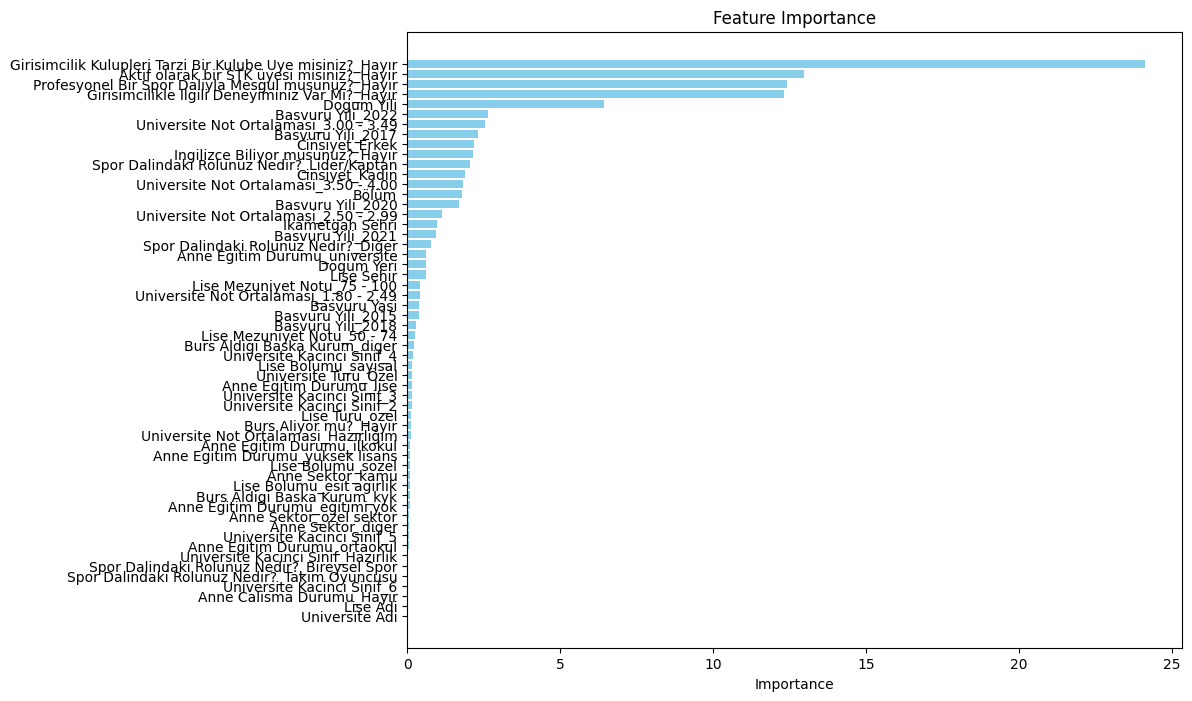

In [23]:
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

# Assuming 'model' is your trained CatBoost model and 'X' is your feature set
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X.columns

# Create a DataFrame for better visualization
import pandas as pd

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [24]:
# import pandas as pd
# import re
# import numpy as np
# from datetime import datetime
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, Lars, LassoLars
# from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.linear_model import HuberRegressor, OrthogonalMatchingPursuit
# from sklearn.dummy import DummyRegressor
# from sklearn.experimental import enable_hist_gradient_boosting
# from catboost import CatBoostRegressor
# import lightgbm as lgb
# import xgboost as xgb

In [25]:
# models = {
#     'Linear Regression': LinearRegression(),
#     'Ridge Regression': Ridge(),
#     'Lasso Regression': Lasso(),
#     'Elastic Net': ElasticNet(),
#     'Bayesian Ridge': BayesianRidge(),
#     'Least Angle Regression': Lars(),
#     'Lasso Least Angle Regression': LassoLars(),
#     'Gradient Boosting Regressor': GradientBoostingRegressor(),
#     'Random Forest Regressor': RandomForestRegressor(),
#     'Extra Trees Regressor': ExtraTreesRegressor(),
#     'AdaBoost Regressor': AdaBoostRegressor(),
#     'Decision Tree Regressor': DecisionTreeRegressor(),
#     'K Neighbors Regressor': KNeighborsRegressor(),
#     'Huber Regressor': HuberRegressor(),
#     'Orthogonal Matching Pursuit': OrthogonalMatchingPursuit(),
#     'Dummy Regressor': DummyRegressor(strategy='mean'),
#     'Extreme Gradient Boosting': xgb.XGBRegressor(),
#     'Light Gradient Boosting Machine': lgb.LGBMRegressor(),
#     'CatBoost Regressor': CatBoostRegressor(learning_rate=0.1, depth=6, iterations=500, verbose=0),
#     'Hist Gradient Boosting Regressor': HistGradientBoostingRegressor()
# }

# results = {}

# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     results[name] = rmse
#     print(f'{name}: RMSE = {rmse}')

# results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE'])
# print(results_df.sort_values(by='RMSE'))